In [59]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [60]:
# read the pickle file
with open('../tracker_stubs/ball_detections.pkl', 'rb') as f:
    ball_positions = pickle.load(f)

In [61]:
ball_positions = [x.get(1, []) for x in ball_positions] # the list will be empty when there are no detections
df_ball_positions = pd.DataFrame(ball_positions, columns = ['x1', 'y1', 'x2', 'y2'])

# interpolate the missing values
df_ball_positions = df_ball_positions.interpolate()
df_ball_positions = df_ball_positions.bfill() # prevents interpolating first frame

In [62]:
df_ball_positions

,x1,y1,x2,y2
0,892.720459,615.906555,911.336060,636.187561
1,892.720459,615.906555,911.336060,636.187561
2,878.350928,630.013708,896.637012,650.013782
3,863.981396,644.120862,881.937964,663.840002
4,849.611865,658.228015,867.238916,677.666223
...,...,...,...,...
209,1188.963119,248.454861,1197.876778,258.497332
210,1185.300293,235.130005,1193.912476,244.928024
211,1183.682068,225.285629,1192.741211,236.298759
212,1182.063843,215.441254,1191.569946,227.669495


In [63]:
# get center coordinate of ball
df_ball_positions['mid_y'] = (df_ball_positions['y1'] + df_ball_positions['y2']) / 2
df_ball_positions['mid_y_rolling_mean'] = df_ball_positions['mid_y'].rolling(window = 5, min_periods = 1, center = False).mean() # remove outliers

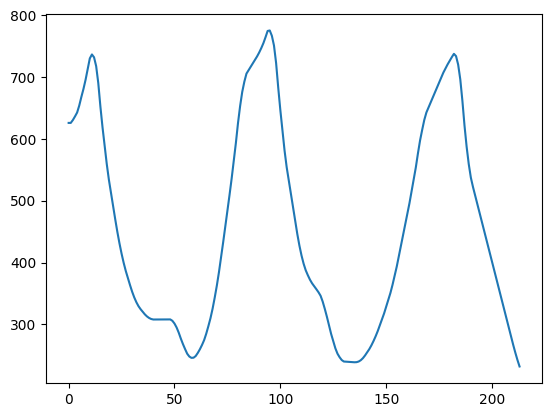

In [64]:
# plot mid_y_rolling_mean
plt.plot(df_ball_positions['mid_y_rolling_mean'])

In [65]:
# the point where y changes abruptly (either increases or decreases) is the point where ball is being hit by the racket

In [66]:
# identify when the y changes
df_ball_positions['delta_y'] = df_ball_positions['mid_y_rolling_mean'].diff() # calculates diff btwn consecutive rows

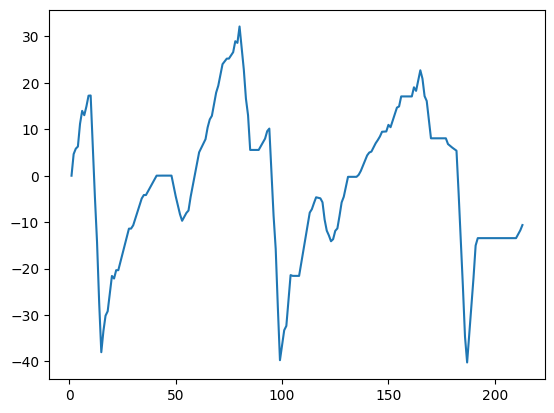

In [67]:
# plot mid_y_rolling_mean
plt.plot(df_ball_positions['delta_y'])

In [68]:
df_ball_positions['ball_hit'] = 0

In [69]:
minimum_change_frames_for_hit = 25 # approx number of frames for which there was no abrupt change in ball direction
for i in range(1, len(df_ball_positions) - int(minimum_change_frames_for_hit * 1.2)): # 1.2 = increase by 20%
    negative_position_change = df_ball_positions['delta_y'].iloc[i] > 0 and df_ball_positions['delta_y'].iloc[i+1] < 0 # first increasing and then decreasing
    positive_position_change = df_ball_positions['delta_y'].iloc[i] < 0 and df_ball_positions['delta_y'].iloc[i+1] > 0 # first decreasing and then increasing

    if negative_position_change or positive_position_change:
        change_count = 0 # keeps track of how many frames the change goes on for
        for change_frame in range(i + 1, i + int(minimum_change_frames_for_hit * 1.2) + 1):
            negative_position_change_following_frame = df_ball_positions['delta_y'].iloc[i] > 0 and df_ball_positions['delta_y'].iloc[change_frame] < 0 # compare original frame with future frames
            positive_position_change_following_frame = df_ball_positions['delta_y'].iloc[i] < 0 and df_ball_positions['delta_y'].iloc[change_frame] > 0

            if negative_position_change and negative_position_change_following_frame:
                change_count += 1
            elif positive_position_change and positive_position_change_following_frame:
                change_count += 1

        if change_count>minimum_change_frames_for_hit-1:
            df_ball_positions['ball_hit'].iloc[i] = 1 # If enough frames (≥ 25) show the direction has changed and stayed changed, it flags the frame i as a ball hit.
frame_nums_with_ball_hits = df_ball_positions[df_ball_positions['ball_hit'] == 1].index.tolist()

C:\Users\tanma\AppData\Local\Temp\ipykernel_4668\1220799590.py:18: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_ball_positions['ball_hit'].iloc[i] = 1 # If enough frames (≥ 25) show the direction has changed and stayed changed, it flags 

In [70]:
df_ball_positions[df_ball_positions['ball_hit'] == 1]

,x1,y1,x2,y2,mid_y,mid_y_rolling_mean,delta_y,ball_hit
11,778.221924,717.782410,796.419312,738.028748,727.905579,736.812653,6.405017,1
58,926.669275,243.490701,936.256641,254.049216,248.769958,245.881316,-2.159865,1
95,624.546509,749.446106,641.117157,766.843811,758.144958,775.608555,0.773283,1
135,751.359802,233.522507,759.471924,243.000137,238.261322,238.742655,-0.240667,1
182,1294.820923,741.348267,1311.882935,759.578247,750.463257,737.828592,5.389325,1
